In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import print_function, absolute_import, division

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from wgomoku import (
    GomokuBoard, Heuristics, GomokuTools as gt, HeuristicGomokuPolicy)

In [4]:
#board size:
N=20

In [5]:
def make_tfr_input_fn(filename_pattern, batch_size, N, options):
    
    import tensorflow as tf
    N_p = N + 2
    feature_spec = {
        'state': tf.FixedLenFeature([N_p * N_p * 2], tf.float32),
        'qvalue': tf.FixedLenFeature([N_p * N_p], tf.float32)
    }

    def _input_fn():
        dataset = tf.data.experimental.make_batched_features_dataset(
            file_pattern=filename_pattern,
            batch_size=batch_size,
            features=feature_spec,
            shuffle_buffer_size=options['shuffle_buffer_size'],
            prefetch_buffer_size=options['prefetch_buffer_size'],
            reader_num_threads=options['reader_num_threads'],
            parser_num_threads=options['parser_num_threads'],
            label_key='qvalue')

        if options['distribute']:
            return dataset 
        else:
            return dataset.make_one_shot_iterator().get_next()
    return _input_fn

In [6]:
options = {
    'shuffle_buffer_size': 1024,
    'prefetch_buffer_size': 1024,
    'reader_num_threads': 4,
    'parser_num_threads': 4,
    'train_data_pattern': "gs://gomoku-data/tfrecords/*",
    'train_batch_size': 128,
    'max_train_steps': 100000,
    'eval_data_pattern': "gs://gomoku-data/tfrecords/*",
    'eval_batch_size': 32,
    'eval_steps': 10,
    'throttle_secs': 1200,
    'learning_rate': 1e-3,
    'distribute': False,
    'model_dir': "gs://gomoku-data/model",
    'save_summary_steps': 128,
    'save_checkpoints_steps': 1024,
    'log_step_count_steps': 64,
    'optimizer': 'adam'
}

train_input_fn = make_tfr_input_fn(options['train_data_pattern'], 
                               options['train_batch_size'],
                               N, options)    

eval_input_fn = make_tfr_input_fn(options['eval_data_pattern'], 
                              options['eval_batch_size'],
                              N, options)

In [7]:
from tensorflow.feature_column import numeric_column as num
feature_columns = [num('state', shape=((N+2)*(N+2)*2))]
feature_columns

[NumericColumn(key='state', shape=(968,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [8]:
def hypothesis(features, feature_columns, options):

    print("===================================================")
    print("Hypothesis")
    print("===================================================")
    
    #f_state = features['state']
    #reshaped = tf.reshape(f_state, (-1, N+2, N+2, 2))
    #print("===================================================")
    #print(f_state)
    #print(reshaped)
    #print(feature_columns)
    #print("===================================================")
    
    input_layer = tf.feature_column.input_layer( 
        features, feature_columns=feature_columns)

    reshaped = tf.reshape(input_layer, [-1, N+2, N+2, 2], name='reshape_input')
    
    #print("===================================================")
    #print(reshaped)
    #print(input_layer)
    #print("===================================================")

    conv0 = tf.layers.conv2d(inputs=reshaped, filters=1024, kernel_size=[9,9], 
                             strides=[1,1], padding='SAME', activation=tf.nn.elu)
    conv1 = tf.layers.conv2d(inputs=conv0, filters=512, kernel_size=[7,7], 
                             strides=[1,1], padding='SAME', activation=tf.nn.elu)
    conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=[7,7], 
                             strides=[1,1], padding='SAME', activation=tf.nn.elu)
    conv3 = tf.layers.conv2d(inputs=conv2, filters=1, kernel_size=[5,5], 
                             strides=[1,1], padding='SAME')

    return conv3

In [9]:
from make_model_fn import make_model_fn
model_fn = make_model_fn(feature_columns, options, hypothesis)

ImportError: No module named 'make_model_fn'

In [53]:
def serving_input_fn():
    placeholders = {
        'state': tf.placeholder(name='state', shape=[(N+2)*(N+2)*2, None], dtype=tf.float32)
    }
    return tf.estimator.export.ServingInputReceiver(placeholders, placeholders)

In [54]:
train_input_fn()

({'state': <tf.Tensor 'IteratorGetNext_5:0' shape=(128, 968) dtype=float32>},
 <tf.Tensor 'IteratorGetNext_5:1' shape=(128, 484) dtype=float32>)

In [55]:
exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)

train_spec = tf.estimator.TrainSpec(
    input_fn=train_input_fn, 
    max_steps=options['max_train_steps'])

eval_spec = tf.estimator.EvalSpec(
    input_fn=eval_input_fn, exporters=exporter,
    steps = options['eval_steps'],
    throttle_secs=options['throttle_secs'],
    start_delay_secs=0)

In [56]:
from tensorflow.estimator import RunConfig
from tensorflow.contrib.distribute import MirroredStrategy

strategy = MirroredStrategy() if options['distribute'] else None
config = RunConfig(model_dir=options['model_dir'],
                   save_summary_steps=options['save_summary_steps'],
                   train_distribute=strategy, 
                   save_checkpoints_steps=options['save_checkpoints_steps'],
                   log_step_count_steps=options['log_step_count_steps'])

estimator = tf.estimator.Estimator(
        config=config,
        model_fn=model_fn)


INFO:tensorflow:Using config: {'_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8b96426eb8>, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_experimental_distribute': None, '_save_checkpoints_secs': None, '_device_fn': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_master': '', '_save_checkpoints_steps': 1024, '_keep_checkpoint_max': 5, '_train_distribute': None, '_is_chief': True, '_service': None, '_protocol': None, '_task_id': 0, '_model_dir': 'gs://gomoku-data/model', '_save_summary_steps': 128, '_num_ps_replicas': 0, '_eval_distribute': None, '_evaluation_master': '', '_log_step_count_steps': 64, '_global_id_in_cluster': 0, '_num_worker_replicas': 1}


In [57]:
##################################################################
#   Finally, train and evaluate the model
##################################################################
final_eval = tf.estimator.train_and_evaluate(
    estimator, 
    train_spec=train_spec, 
    eval_spec=eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1024 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
Mode: train
Hypothesis
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into gs://gomoku-data/model/model.ckpt.
INFO:tensorflow:loss = 18408.156, step = 0
INFO:tensorflow:global_step/sec: 1.95166
INFO:tensorflow:loss = 9978.11, step = 64 (32.793 sec)
INFO:tensorflow:global_step/sec: 1.86591
INFO:tensorflow:loss = 9602.587, step = 128 (34.300 sec)
INFO:tensorflow:global_step/sec: 1.96022
INFO:tensorflow:loss = 9069.279, ste

KeyboardInterrupt: 

In [35]:
latest_model=!gsutil ls gs://gomoku-data/model2/export/exporter | grep -v temp | sort | tail -1
latest_model = latest_model[0]
latest_model

'gs://gomoku-data/model2/export/exporter/1554770782/'

In [36]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://gomoku-data/model2/export/exporter/1554770782/variables/variables


In [37]:
from GomokuData import data_from_game
stones=gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')
heuristics = Heuristics(kappa=3.0)
board = GomokuBoard(heuristics=heuristics, N=20, stones=stones, disp_width=10)
policy = HeuristicGomokuPolicy(board=board, style=2)
board = GomokuBoard(heuristics=heuristics, N=20, stones=stones, disp_width=10)

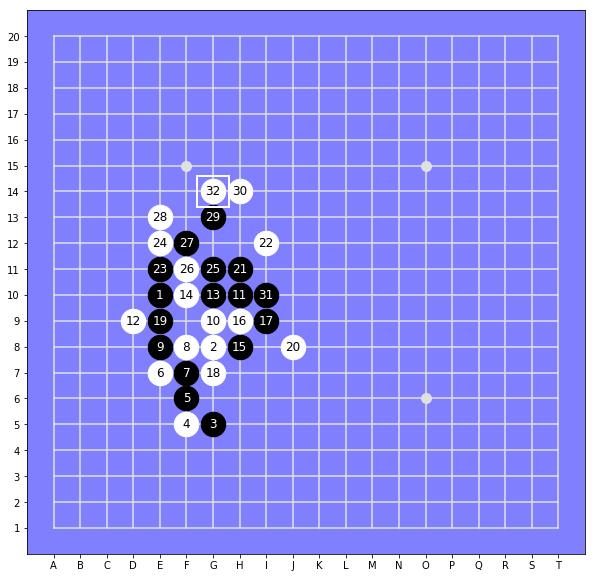

In [42]:
board.undo().display()

In [43]:
data = data_from_game(board, policy, heuristics)
idx = 5
data[0][idx].shape

(22, 22, 2)

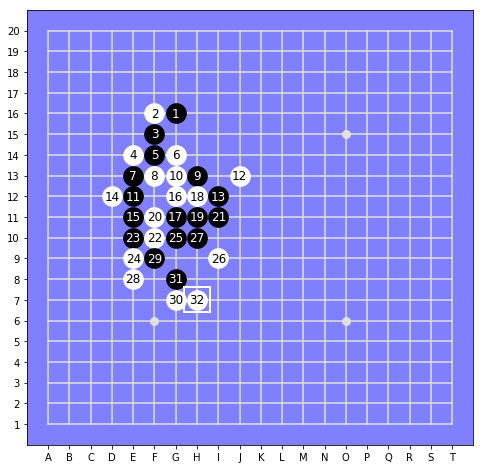

In [44]:
s = data[0][idx]
field = np.rollaxis(s.reshape(22,22,2), 2, 0).astype(np.int)
unwrapped = (field[0]+field[1]*2)[1:-1].T[1:-1].T
unwrapped
r,c = np.where(unwrapped == 1)
moves_b = list(zip(r,c))
r,c = np.where(unwrapped == 2)
moves_w = list(zip(r,c))
moves_b, moves_w = (moves_b, moves_w) if len(moves_b) == len(moves_w) else (moves_w, moves_b)
moves_b = [gt.m2b(move, N) for move in moves_b]
moves_w = [gt.m2b(move, N) for move in moves_w]
if len(moves_b) > len(moves_w):
    last_move = moves_b[-1]
stones=[]
for two_moves in zip(moves_b, moves_w):
    for i in [0, 1]:
        stones.append((two_moves[i][0], two_moves[i][1]))
if len(moves_b) > len(moves_w):
    stones.append((moves_b[-1][0], moves_b[-1][1]))
len(stones)
board = GomokuBoard(heuristics, N, disp_width=8, stones=stones)
board.display()

In [45]:
sample={'state': np.transpose([s.flatten()])}

In [64]:
q = estimator(sample)
q = q['output'][0]
q = np.rollaxis(q, 2, 0)
q = np.sign(q)+1
_, x, y = np.where(q==2)

In [67]:
[gt.m2b(p, 20) for p in list(zip(x,y))]

[array([10, 12]), array([ 7, 11]), array([6, 7]), array([20,  2])]